# Homework - week 5

## Libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error, auc, roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import KFold

## Data import

In [92]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


## Preparation

In [93]:
data.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [94]:
data.card = (data.card == 'yes').astype(int)
data.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

In [95]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

## Question 1

In [96]:
df_train.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
1105,0,3,40.50000,4.0128,0.000299,0.00000,no,no,1,12,1,17
431,0,1,32.33333,6.0000,0.000200,0.00000,yes,no,4,18,1,4
407,1,1,29.16667,2.2000,0.038205,69.79333,no,no,0,49,1,7
1217,1,1,54.66667,7.2900,0.106536,647.20670,yes,no,2,78,1,9
1133,1,0,25.00000,3.3984,0.000353,0.00000,yes,no,2,29,0,4


In [97]:
cols = list((df_train).columns)
numerical = df_train.select_dtypes(include=['int64', 'float64']).drop('card', axis=1).columns
categorical = [i for i in cols if i not in numerical]

In [98]:
scores = []
for col in numerical:
    score = roc_auc_score(df_train.card, df_train[col])
    if score < 0.5:
        score = roc_auc_score(df_train.card, -df_train[col])
    else:
        pass
    scores.append(score)

pd.Series(dict(zip(numerical,scores))).sort_values(ascending=False)

expenditure    0.991042
share          0.989184
reports        0.716663
active         0.604317
income         0.590805
majorcards     0.534386
dependents     0.532776
months         0.529422
age            0.524002
dtype: float64

## Question 2

In [108]:
def preprocess(data):
    selected_cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp", 'card']
    data = data[selected_cols].copy()

    data.card = (data.card == 'yes').astype(int)

    df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.card.values
    y_val = df_val.card.values
    y_test = df_test.card.values

    del df_train['card']
    del df_val['card']
    del df_test['card']

    return df_train, df_val, df_test, y_train, y_val, y_test
    
def vectorize(df):

    dv = DictVectorizer(sparse=False)

    dict = df.to_dict(orient='records')
    X = dv.fit_transform(dict)

    return X, dv

def train_model(df_train, y_train, C=1):
    X_train, dv = vectorize(df_train)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return model, dv

def predict_model(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [100]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')
df_train, df_val, df_test, y_train, y_val, y_test = preprocess(data)
model, dv = train_model(df_train, y_train)
y_pred = predict_model(df_val, dv, model)
print(roc_auc_score(y_val,y_pred).round(3))

0.995


## Question 3

In [101]:
def scores(y_val,y_pred):
    scores = []

    # Creating an array of evenly-spaced probabilities from 0 to 1 (aka 0, 0.1, 0.2, ..., 0.99, 1)
    thresholds = np.linspace(0, 1, 101)

    # Printing true positives & negatives, false positives & negatives for each rate 
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        # List of tuples is created per threshold
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['recall'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)


    return df_scores

<AxesSubplot:xlabel='threshold'>

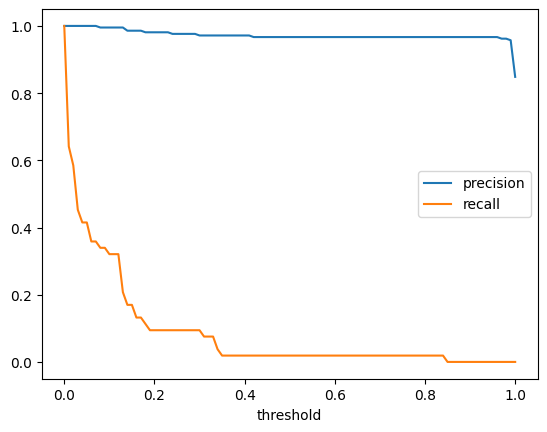

In [102]:
tresh = np.linspace(0,1,101)
df_scores = scores(y_val, y_pred)
df_scores[['threshold','precision','recall']].plot(x='threshold')

## Question 4

<AxesSubplot:xlabel='threshold'>

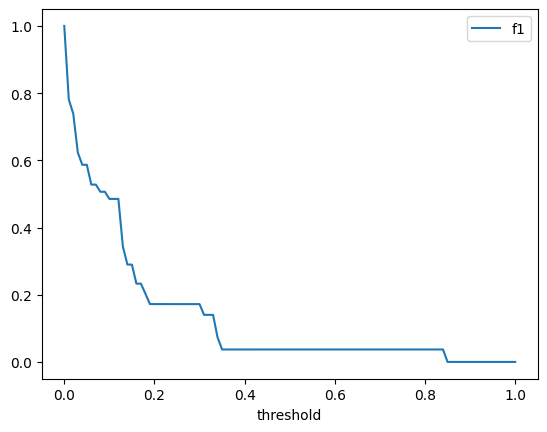

In [103]:
df_scores[['threshold','f1']].plot(x='threshold')

## Question 5

In [104]:
def preprocess(data):
    selected_cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp", 'card']
    data = data[selected_cols].copy()

    data.card = (data.card == 'yes').astype(int)

    df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

    df_full_train = df_train.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_full_train = df_full_train.card.values
    y_train = df_train.card.values
    y_val = df_val.card.values
    y_test = df_test.card.values

    del df_full_train['card']
    del df_train['card']
    del df_val['card']
    del df_test['card']

    return df_full_train, df_train, df_val, df_test, y_full_train, y_train, y_val, y_test

In [107]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

selected_cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp", 'card']

scores = []

for train_idx, val_idx in kfold.split(df_full_train[selected_cols]):
    # the k-fold split uses index to shuffle the data
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    # y values come from dataset
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    # training and predicting
    model, dv = train_model(df_train, y_train)
    y_pred = predict_model(df_test, dv, model)
    
    # AUC
    auc = roc_auc_score(y_test, y_pred)
    scores.append(auc)

print(f'{np.mean(scores):.5f} +- {np.std(scores):.5f}')

0.99591 +- 0.00027


## Question 6

In [111]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

selected_cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp", 'card']

scores = []

for C in [0.01, 0.1, 1, 10]:
    for train_idx, val_idx in kfold.split(df_full_train[selected_cols]):
        # the k-fold split uses index to shuffle the data
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        # y values come from dataset
        y_train = df_train.card.values
        y_val = df_val.card.values
        
        # training and predicting
        model, dv = train_model(df_train, y_train, C=C)
        y_pred = predict_model(df_test, dv, model)
        
        # AUC
        auc = roc_auc_score(y_test, y_pred)
        scores.append(auc)

    print(f'C={C}: {np.mean(scores):.3f} +- {np.std(scores):.10f}')

C=0.01: 0.994 +- 0.0003589238
C=0.1: 0.995 +- 0.0010531273
C=1: 0.995 +- 0.0010205081
C=10: 0.995 +- 0.0009960024
